##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 mintues to run on a single P100 GPU.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import random
print(tf.__version__)

2.0.0


## Download and prepare the dataset

We are using the ROCStories Corpora.

In [2]:
# Download the file
#path_to_zip = tf.keras.utils.get_file(
#    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
 #   extract=True)

path_to_file = os.path.dirname(".")+"ROCStories.txt"


In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.rstrip().strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
#Changing so that we just do two sentences
  L = w.replace("!",".").replace("?", ".").split(".")
  w = L[0] + '<endsentence>' + L[1]
  w = '<start> ' + w + ' <end>'
  return w

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
#print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book <endsentence> <end>


In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('<|endoftext|>')

  story_pairs = [[preprocess_sentence(w) for i in range(0,2)]  for w in lines[:num_examples]]

  return zip(*story_pairs)

In [6]:
left_story,right_story = create_dataset(path_to_file, 100)
print(left_story[2])

<start> marcus needed clothing for a business casual event <endsentence> all of his clothes were either too formal or too casual  <end>


In [7]:
def generate_random_stories(from_stories, num_examples=5000,max_length=103, min_length=50):
    ret = []
    for i in range(0,num_examples):
        app = ''
        r_int = random.randint(min_length,max_length)
        for j in range(0,r_int):
            c_story = random.choice(from_stories).split(" ")
            n_word = random.choice(c_story)
            app += ' ' + n_word
        ret.append(app)
    return ret
#L = generate_random_stories(left_story) 

def generate_random_story(from_stories, max_length, min_length):
    app = ''
    r_int = random.randint(min_length,max_length)
    for j in range(0,r_int):
        c_story = random.choice(from_stories).split(" ")
        n_word = random.choice(c_story)
        app += ' ' + n_word
    return app

def generate_kinda_random_story(from_stories):
    app = ''
    c_story = random.choice(from_stories).split(" ")
    for w in c_story:
        r = random.randint(0,4)
        if(r == 4):
            n_story = random.choice(from_stories).split(" ")
            n_word = random.choice(n_story)
            app += ' ' + n_word
        else:
            app += ' ' + w
    return app
def generate_kinda_random_stories(from_stories, num_examples):
    ret = []
    for i in range(0,num_examples):
        ret.append(generate_kinda_random_story(from_stories))
    return ret

In [8]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [9]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=5000):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  rand_lang = generate_random_stories(targ_lang,num_examples=num_examples,max_length=max_length(input_tensor), min_length=(int(max_length(input_tensor)/2)))
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  rand_tensor, rand_lang_tokenizer = tokenize(rand_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer, rand_lang_tokenizer, rand_tensor

def load_corrupted_dataset(path, num_examples=5000):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  rand_lang = generate_kinda_random_stories(targ_lang,num_examples)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  rand_tensor, rand_lang_tokenizer = tokenize(rand_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer, rand_lang_tokenizer, rand_tensor

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [11]:
# Try experimenting with the size of that dataset
num_examples = 10000
input_tensor, target_tensor, inp_lang, targ_lang, rand_lang, rand_tensor = load_corrupted_dataset(path_to_file, num_examples)


# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
#rand_tensor = generate_random_dataset(num_examples,max_length_targ)

In [12]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
rand_tensor_train, rand_tensor_val = train_test_split(rand_tensor,test_size=0.2)
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

8000 8000 2000 2000


In [13]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[-1])
print("random language")
convert(rand_lang, rand_tensor_train[26])

Input Language; index to word mapping
1 ----> <start>
24 ----> my
203 ----> cat
11 ----> and
14 ----> i
283 ----> moved
5 ----> to
6 ----> a
29 ----> new
428 ----> apartment
2 ----> <endsentence>
14 ----> i
57 ----> loved
24 ----> my
29 ----> new
428 ----> apartment
17 ----> ,
42 ----> but
24 ----> my
203 ----> cat
82 ----> didn
37 ----> t
3 ----> <end>

Target Language; index to word mapping
1 ----> <start>
24 ----> my
203 ----> cat
11 ----> and
14 ----> i
283 ----> moved
5 ----> to
6 ----> a
29 ----> new
428 ----> apartment
2 ----> <endsentence>
14 ----> i
57 ----> loved
24 ----> my
29 ----> new
428 ----> apartment
17 ----> ,
42 ----> but
24 ----> my
203 ----> cat
82 ----> didn
37 ----> t
3 ----> <end>
random language
3 ----> <start>
9 ----> she
28 ----> day
14 ----> i
108 ----> saw
6 ----> a
2427 ----> cab
482 ----> stop
13 ----> in
24 ----> my
2316 ----> contacts
38 ----> that
1 ----> <end>
2 ----> <endsentence>
4 ----> the
889 ----> driver
86 ----> asked
14 ----> i
180 ----> calle

### Create a tf.data dataset

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 16
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
vocab_rand_size = len(rand_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train,rand_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch, example_rand_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape, example_rand_batch.shape

#print(steps_per_epoch)

(TensorShape([16, 35]), TensorShape([16, 35]), TensorShape([16, 34]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [17]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))




In [18]:
def get_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(25))
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(1))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output),real_output) + cross_entropy(tf.zeros_like(fake_output),fake_output)

def fake_encoder_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

discriminator = get_discriminator()

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [19]:
real_encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = real_encoder.initialize_hidden_state()
sample_output, sample_hidden = real_encoder(example_input_batch, sample_hidden)

fake_encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
fake_encoder_optimizer = tf.keras.optimizers.Adam(1e-4)
fake_sample_hidden = fake_encoder.initialize_hidden_state()
fake_sample_output, fake_sample_hidden = fake_encoder(example_rand_batch, fake_sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
print('fake sample shape: () {}'.format(fake_sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (16, 35, 1024)
Encoder Hidden state shape: (batch size, units) (16, 1024)
fake sample shape: () (16, 1024)


In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (16, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (16, 35, 1)


In [22]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (16, 8865)


## Define the optimizer and the loss function

In [24]:
real_encoder_optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(real_encoder_optimizer=real_encoder_optimizer,
                                 fake_encoder_optimizer=fake_encoder_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 real_encoder=real_encoder,
                                 discriminator=discriminator,
                                 fake_encoder=fake_encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [26]:
'''
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = real_encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = real_encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  real_encoder_optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss
'''
@tf.function
def train_step(inp, targ, rand, enc_hidden):
  loss = 0
  fake_enc_loss = 0
  discr_loss = 0
  with tf.GradientTape() as real_enc_tape, tf.GradientTape() as fake_enc_tape, tf.GradientTape() as discr_tape:
        
    enc_output, real_enc_hidden = real_encoder(inp, enc_hidden)
    
    #our addition
    fake_enc_output, fake_enc_hidden = fake_encoder(rand, enc_hidden)
    real_output = discriminator(enc_output, training=True)
    fake_output = discriminator(fake_enc_output, training=True)
    discr_loss = discriminator_loss(real_output,fake_output)
    fake_enc_loss = fake_encoder_loss(fake_output)
    #real_encoder_additional_loss = fake_encoder_loss(real_output) #fel is same.
    #loss += real_encoder_additional_loss
    
    dec_hidden = real_enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  real_encoder_variables = real_encoder.trainable_variables + decoder.trainable_variables
  fake_encoder_variables = fake_encoder.trainable_variables
  discriminator_variables = discriminator.trainable_variables
  real_encoder_gradients = real_enc_tape.gradient(loss, real_encoder_variables)
  fake_encoder_gradients = fake_enc_tape.gradient(fake_enc_loss, fake_encoder_variables)
  discriminator_gradients = discr_tape.gradient(discr_loss, discriminator_variables)

  real_encoder_optimizer.apply_gradients(zip(real_encoder_gradients, real_encoder_variables))
  fake_encoder_optimizer.apply_gradients(zip(fake_encoder_gradients, fake_encoder_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_variables))

  return batch_loss

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
EPOCHS = 30

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = real_encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp,targ,rand)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp,targ,rand,enc_hidden)
    total_loss += batch_loss

    if batch % 10 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch, batch_loss.numpy()))
  #  if(batch*steps_per_epoch >= num_examples):
   #     break
  # saving (checkpoint) the model every 2 epochs
  #if (epoch + 1) % 2 == 0:
  checkpoint.save(file_prefix = checkpoint_prefix)
  
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss.numpy() / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
'''
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = real_encoder.initialize_hidden_state()
  total_loss = 0
  i = 0
  for (batch, (inp,targ,_)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp,targ,enc_hidden)
    total_loss += batch_loss

    if batch % 10 == 0:
      print('Epoch {} Batch {}'.format(epoch + 1,
                                                   batch))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  
  '''

Epoch 1 Batch 0 Loss 1.4193
Epoch 1 Batch 10 Loss 1.8398
Epoch 1 Batch 20 Loss 1.2976
Epoch 1 Batch 30 Loss 1.6603
Epoch 1 Batch 40 Loss 1.3947
Epoch 1 Batch 50 Loss 1.8736
Epoch 1 Batch 60 Loss 1.4563
Epoch 1 Batch 70 Loss 1.5538
Epoch 1 Batch 80 Loss 1.5377
Epoch 1 Batch 90 Loss 1.6121
Epoch 1 Batch 100 Loss 1.9766
Epoch 1 Batch 110 Loss 2.4168
Epoch 1 Batch 120 Loss 1.9788
Epoch 1 Batch 130 Loss 2.3465
Epoch 1 Batch 140 Loss 2.0674
Epoch 1 Batch 150 Loss 2.1606
Epoch 1 Batch 160 Loss 2.2050
Epoch 1 Batch 170 Loss 1.7521
Epoch 1 Batch 180 Loss 2.0990
Epoch 1 Batch 190 Loss 2.0339
Epoch 1 Batch 200 Loss 1.7322
Epoch 1 Batch 210 Loss 1.8639
Epoch 1 Batch 220 Loss 1.5468
Epoch 1 Batch 230 Loss 1.4893
Epoch 1 Batch 240 Loss 1.4283
Epoch 1 Batch 250 Loss 2.0170
Epoch 1 Batch 260 Loss 1.5541
Epoch 1 Batch 270 Loss 1.9226
Epoch 1 Batch 280 Loss 1.3999
Epoch 1 Batch 290 Loss 1.7015
Epoch 1 Batch 300 Loss 1.6379
Epoch 1 Batch 310 Loss 1.7728
Epoch 1 Batch 320 Loss 1.6733
Epoch 1 Batch 330 Los

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [27]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = []
  for i in sentence.split(' '):
    if(i == "." or i=="?" or i == "!"):
        inputs.append(inp_lang.word_index["<endsentence>"])
    else:
      if(i != ""):
         inputs.append(inp_lang.word_index[i])
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = real_encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot


def evaluate_gen(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  #sentence = preprocess_sentence(sentence)
  #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = []
  for i in sentence.split(' '):
    if(i == "." or i=="?" or i == "!"):
        inputs.append(inp_lang.word_index["<endsentence>"])
    else:
      if(i != ""):
         inputs.append(inp_lang.word_index[i])
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = fake_encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [28]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [29]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

current_length = 35
def generate(from_stories):
  story = generate_random_story(from_stories,current_length,current_length)
  print(story)
  result, sentence, attention_plot = evaluate_gen(story) 

  print('Input: %s' % (sentence))
  print('Generated sentences: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

def generate_kr(from_stories):
  story = generate_kinda_random_story(from_stories)
  print(story)
  result, sentence, attention_plot = evaluate_gen(story) 

  print('Input: %s' % (sentence))
  print('Generated sentences: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    

## Restore the latest checkpoint and test

In [30]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<start> tom had a very short temper <endsentence> one day a guest made him very angry  <end>
 <start> james when playing video ran on his a <endsentence> down game on his computer was running thought slow a went
Input:  <start> james when playing video ran on his a <endsentence> down game on his computer was running thought slow a went
Generated sentences: tricia was driving down the dog s old s dog s old s dog s old s dog s old s dog s old s dog s old s dog s old s dog s 


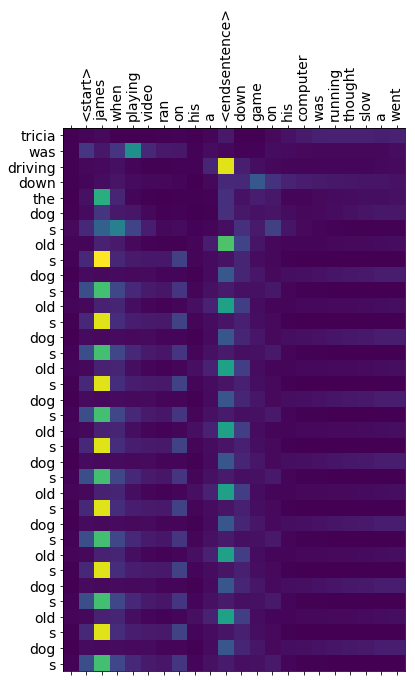

 they jill wanted a recently for her family <endsentence> she went to the <start> store to look for an animal greasy <end>
Input:  they jill wanted a recently for her family <endsentence> she went to the <start> store to look for an animal greasy <end>
Generated sentences: tricia was driving down the man was driving down the man was driving down the man was driving down the man was driving down the man was driving down the man was driving down the 


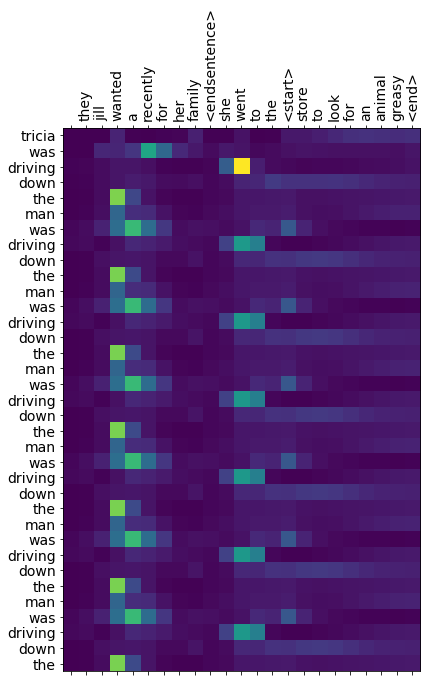

 <start> rita chloe and unk in her crib to mrs sampson stood up and get over to the crib  <end>
Input:  <start> rita chloe and unk in her crib to mrs sampson stood up and get over to the crib  <end>
Generated sentences: tricia was driving down the dog was driving down the dog was driving down the dog was driving down the dog was driving down the dog was driving down the dog was driving down the 


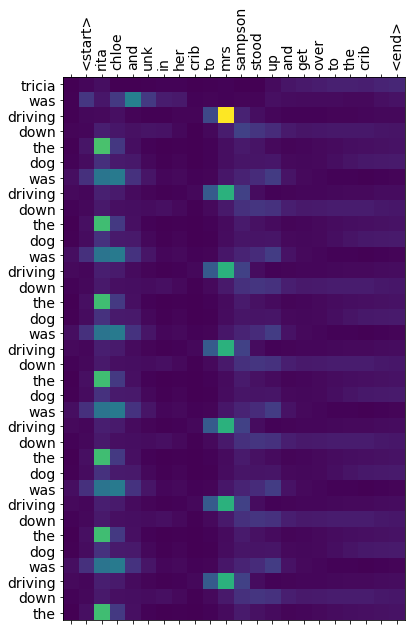

 <start> the prefer was piling up of <endsentence> birthday weatherman said unk would continue all night be <end>
Input:  <start> the prefer was piling up of <endsentence> birthday weatherman said unk would continue all night be <end>
Generated sentences: tricia was driving down the dog s old s dog s old s dog s old s dog s old s dog s old s dog s old s dog s old s dog s 


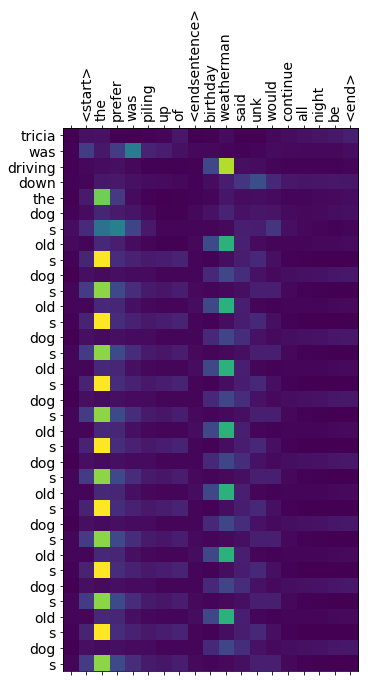

 <start> tabitha needed a new computer <endsentence> her old computer had finally died and it was time a get a new one  controlling
Input:  <start> tabitha needed a new computer <endsentence> her old computer had finally died and it was time a get a new one  controlling
Generated sentences: tricia was driving down the dog and was walking for the man was driving down the dog and was walking for the man was driving down the dog and was walking for the man was 


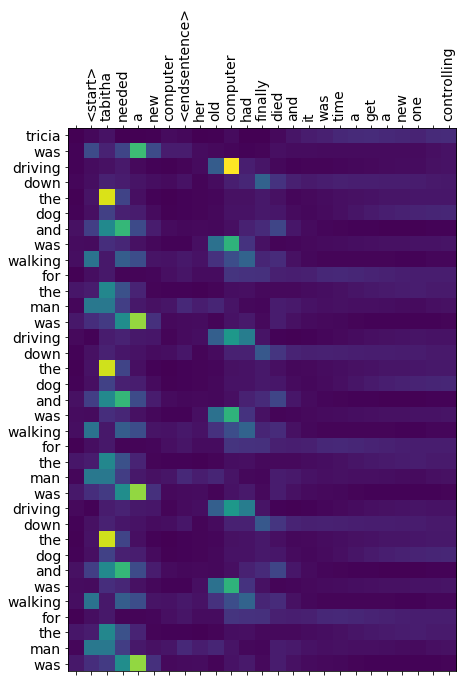

In [49]:
gen_lang, x = create_dataset(path_to_file, 1000)
print(gen_lang[1])
generate_kr(gen_lang)
generate_kr(gen_lang)
generate_kr(gen_lang)
generate_kr(gen_lang)
generate_kr(gen_lang)

IndexError: list index out of range